In [547]:
import pandas as pd
from utils import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Loading, Parsing, and Visualizing Nonlinear Vector Field Data

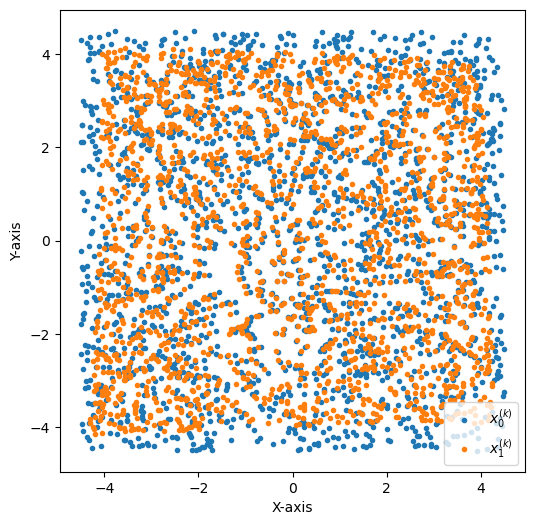

In [548]:
# Load the data from the provided files
file_path_x0 = 'datasets/nonlinear_vectorfield_data_x0.txt'
file_path_x1 = 'datasets/nonlinear_vectorfield_data_x1.txt'

data_x0 = pd.read_csv(file_path_x0, header=None)
data_x1 = pd.read_csv(file_path_x1, header=None)

# Split the strings into separate columns
x = np.array(data_x0[0].str.split(expand=True).astype(float))
y = np.array(data_x1[0].str.split(expand=True).astype(float))

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], marker='.',label='$x^{(k)}_0$')
plt.scatter(y[:, 0], y[:, 1], marker='.',label='$x^{(k)}_1$')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

### Task 3.1.1 Estimate the vector field with a linear operator

Linear Operator (A) = [[-1.0016012   0.08672716]
 [-0.02534942 -4.32671381]]


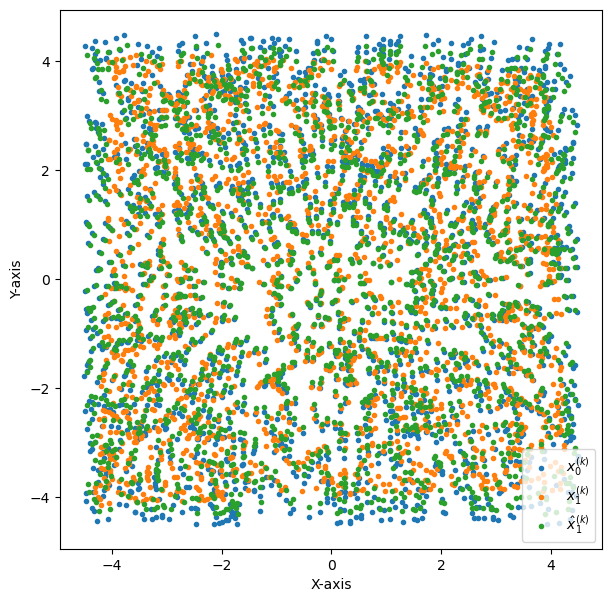

Mean Squared Error (MSE): 0.01864593957965999


In [556]:
def pred(x0, x1, func, args, end_time=0.01):
    # Set time points for evaluation
    t_eval = np.linspace(0, end_time, 100)
    
    # Initialize lists to store solutions
    x1_pred = []

    # Iterate over initial conditions
    for i in range(len(x0)):
        # Solve the initial value problem for a given point
        sol = solve_ivp(func, [0, end_time], x0[i], args=args, t_eval=t_eval)
        
        # Save the final solution
        x1_pred.append([sol.y[0, -1], sol.y[1, -1]])

    # Plotting the original data points
    plt.scatter(x[:, 0], x[:, 1], marker='.', label='$x^{(k)}_0$')
    plt.scatter(y[:, 0], y[:, 1], marker='.', label='$x^{(k)}_1$')
    
    return np.array(x1_pred)

def linear_system(t, y, A):
    return A @ y

# Using np.linalg.lstsq to find the linear operator
# a (data_x0_split) * x (linear_operator) = b (data_x1_split)
A, residuals, rank, s = np.linalg.lstsq(x, (y - x) / 0.01, rcond=None)

print("Linear Operator (A) =", A)

# Plotting the predicted points
plt.figure(figsize=(7, 7))
z = pred(x, y, linear_system, [A])
plt.scatter(z[:, 0], z[:, 1], marker='.', label='$\hat x^{(k)}_1$')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

# Calculating the mean squared error between predicted and actual output vectors
mse = mean_squared_error(y, z)

# Printing the mean squared error
print("Mean Squared Error (MSE):", mse)

### Task 3.1.2 Compute the mean squared error to the solution after Δt as close as possible to x1

In [555]:
def pred(x0, x1, func, args, end_time=0.02):
    # Set time points for evaluation
    t_eval = np.linspace(0, end_time, 1000)
    
    # Initialize a list to store solutions for each initial condition
    sols = []
    
    # Iterate over initial conditions
    for i in range(len(x0)):
        # Solve the initial value problem for a given point
        sol = solve_ivp(func, [0, end_time], x0[i], args=args, t_eval=t_eval)
        sols.append(sol)  # Save the solution for each initial condition
    
    return sols

def linear_system(t, y, A):
    return A @ y

# Predict trajectories for each initial condition
sols = pred(x, y, linear_system, [A], end_time=0.02)

# Create a 3D array to store predicted trajectories at each time point
z2 = np.array([[np.array([sols[j].y[0, i], sols[j].y[1, i]]) for j in range(2000)] for i in range(1000)])

# Calculate and find the minimum MSE and its corresponding time index
min_mse = 100
t_index_min_mse = 0
for i in range(1000):
    mse = mean_squared_error(y, z2[i])
    if mse < min_mse:
        min_mse = mse
        t_index_min_mse = i

# Print the results
print("Minimum Mean Squared Error (MSE):", min_mse)
print("Index of Time when Minimum MSE is Reached:", t_index_min_mse)
print("Corresponding Time Value at Minimum MSE:", sols[0].t[t_index_min_mse])


Minimum MSE: 0.018643478185078725
Index of Time when Minimum MSE is Reached: 510
Corresponding Time Value: 0.01021021021021021


### Part 3.2: Approximate the vector field using radial basis functions

In [558]:
import pandas as pd

# Load data from the files
file_path_x0 = 'datasets/nonlinear_vectorfield_data_x0.txt'
file_path_x1 = 'datasets/nonlinear_vectorfield_data_x1.txt'

data_x0 = pd.read_csv(file_path_x0, sep="\s+", header=None)
data_x1 = pd.read_csv(file_path_x1, sep="\s+", header=None)

# Display the first few rows of the data to understand its structure
data_x0_head = data_x0.head()
data_x1_head = data_x1.head()

data_x0_head, data_x1_head

import numpy as np

# Calculate the vector field as the difference between the two sets of data
vector_field = data_x1.values - data_x0.values

###### using library functions

In [560]:
from scipy.interpolate import RBFInterpolator

# Selecting an initial number of center points (L)
# A common approach is to use a subset of the data points as centers
num_centers = 1000
# Choosing initial centers randomly from the data points
centers_indices = np.random.choice(len(data_x0), num_centers, replace=False)
centers = data_x0.values[centers_indices]

# Initial value for the shape parameter (ϵ)
eps = 0.25

# Constructing the RBF approximation
rbf = RBFInterpolator(centers, vector_field[centers_indices], epsilon=eps, kernel ='gaussian')

# Testing the RBF approximation on a few points
test_points = data_x0.values
approximation = rbf(test_points)

z = approximation + x

# Calculating the mean squared error between predicted and actual output vectors
mse = mean_squared_error(y, z)

# Printing the mean squared error
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.6678637817236662e-10


###### using our own implementation

In [561]:
def rbf_lstsq(x, y, x2, L=100, epsilon=1.0, sq=True, domain=0, dim_x=1, dim_y=1, lib=False, direct=False,
              cond=1.0, func='gaussian', norm='euclidean'):
    """
    Approximate data using radial basis function.
    Tutorial: https://scipy.github.io/old-wiki/pages/Cookbook/RadialBasisFunctions.html

    :param data: Shape (N, n+d), n-dimensional feature x, d-dimensional label y
    :param L: Number of (non-linear) basis functions
    :param epsilon: Bandwidth for xl
    :param sq: Square the bandwidth epsilon
    :param domain: Increases the domain size additively in both direction
    :param dim_x: Dimension of features x
    :param dim_y: Dimension of labels y
    :param lib: Use library implementation of Radial Basis Functions
    :param direct: Use our implementation of linear least squares. NOT recommended!
    :param cond: Cutoff for ‘small’ singular values; used to determine effective rank of "a".
                 Singular values smaller than cond * largest_singular_value are considered zero.
    :param func: The radial basis function; default is 'gaussian', for other basis function
                 see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html
    :param norm: The distance norm; default is 'sqeuclidean', for other distance metrics
                 see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    :return: x, y, y2 coordinates as float list and the matrix c_mat
    """
    domain = 0 if domain < 0 else domain

    # Radial basis function
    if lib:
        # RBF
        _rbf = sp.interpolate.Rbf(x, y, function=func, epsilon=epsilon if sq else np.sqrt(epsilon), norm=norm)
        y2 = _rbf(x2)
        c = None
    else:
        # Our implementation
        phi = np.asarray([[rbf_gauss(xl, xi, epsilon, sq) for xl in x2] for xi in x])  # Shape (1000, 100)
        c = lstsq_direct(phi, y) if direct else sp.linalg.lstsq(phi, y, cond=cond)[0]
        y2 = np.matmul(np.asarray([[rbf_gauss(xl, xi, epsilon, sq) for xl in x2] for xi in x2]), c)  # Shape (100, 1)
    return x, y, x2, y2, c

# Selecting an initial number of center points (L)
# A common approach is to use a subset of the data points as centers
num_centers = 1000
# Choosing initial centers randomly from the data points
centers_indices = np.random.choice(len(data_x0), num_centers, replace=False)
centers = data_x0.values[centers_indices]

# Initial value for the shape parameter (ϵ)
eps = 0.25

# Constructing the RBF approximation
_, _, _, approximation, c = rbf_lstsq(centers, vector_field[centers_indices],data_x0.values, epsilon=1.0, sq=True, domain=0, dim_x=2, dim_y=2, lib=False, direct=False,
              cond=1.0, func='gaussian', norm='euclidean')

z = approximation + x

# Calculating the mean squared error between predicted and actual output vectors
mse = mean_squared_error(y, z)

# Printing the mean squared error
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.327341420633291e-06


##### Search for the best L

In [567]:
min_mse = 1000
min_index = 0

for i in range(100,1100,100):
    print(i)
    num_centers = i
    # Choosing initial centers randomly from the data points
    centers_indices = np.random.choice(len(data_x0), num_centers, replace=False)
    centers = data_x0.values[centers_indices]

    # Initial value for the shape parameter (ϵ)
    eps = 5

    # Constructing the RBF approximation
    _, _, _, approximation, c = rbf_lstsq(centers, vector_field[centers_indices],data_x0.values, epsilon=1.0, sq=True, domain=0, dim_x=2, dim_y=2, lib=False, direct=False,
              cond=1.0, func='gaussian', norm='euclidean')

    # Testing the RBF approximation on a few points
    test_points = data_x0.values

    z = approximation + x

    # Calculating the mean squared error between predicted and actual output vectors
    mse = mean_squared_error(y, z)
    print(mse)
    if(mse<min_mse):
        min_mse = mse
        min_index = i
    
print(min_mse,min_index)

100
0.005498255110276839
200
0.0004429862947538187
300
0.00034369626425355187
400
6.21790385068608e-05
500
1.3091339099161506e-05
600
2.3758776666557353e-06
700
3.2635934980513923e-06
800
1.7102134548916818e-05
900
2.342844970228924e-06
1000
5.269156875542863e-07
5.269156875542863e-07 1000


##### Search for the best $\epsilon$

In [568]:
min_mse = 1000
min_index = 0   

for i in np.linspace(0.1, 0.5, 100):
    num_centers = 1000
    # Choosing initial centers randomly from the data points
    centers_indices = np.random.choice(len(data_x0), num_centers, replace=False)
    centers = data_x0.values[centers_indices]

    # Initial value for the shape parameter (ϵ)
    eps = i

   # Constructing the RBF approximation
    _, _, _, approximation, c = rbf_lstsq(centers, vector_field[centers_indices],data_x0.values, epsilon=1.0, sq=True, domain=0, dim_x=2, dim_y=2, lib=False, direct=False,
              cond=1.0, func='gaussian', norm='euclidean')

    # Testing the RBF approximation on a few points
    test_points = data_x0.values

    z = approximation + x


    # Calculating the mean squared error between predicted and actual output vectors
    mse = mean_squared_error(y, z)
    if(mse<min_mse):
        min_mse = mse
        min_index = i
    
print(min_mse,min_index)

1.963832730318201e-08 0.45151515151515154


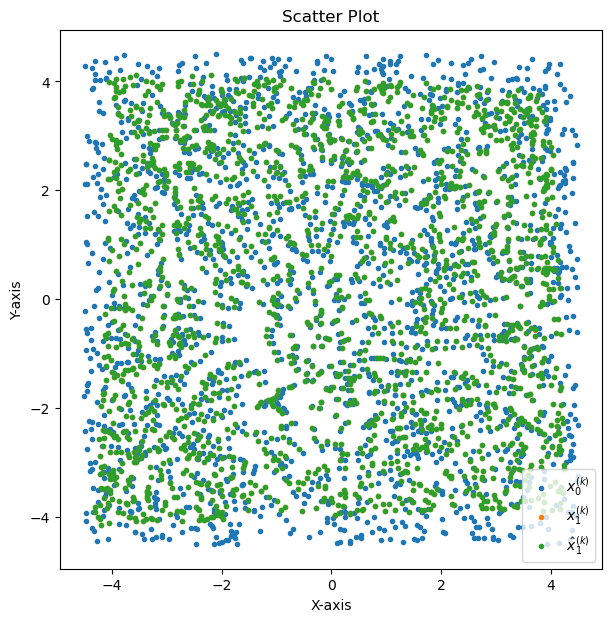

Mean Squared Error (MSE): 7.449331886730552e-12


In [565]:
# Scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(x[:, 0], x[:, 1], marker='.',label='$x^{(k)}_0$')
plt.scatter(y[:, 0], y[:, 1], marker='.',label='$x^{(k)}_1$')
plt.scatter(z[:, 0], z[:, 1], marker='.',label='$\hat x^{(k)}_1$')
plt.title('Scatter Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

# Printing the mean squared error
print("Mean Squared Error (MSE):", mse)

###### Visualize the vector field

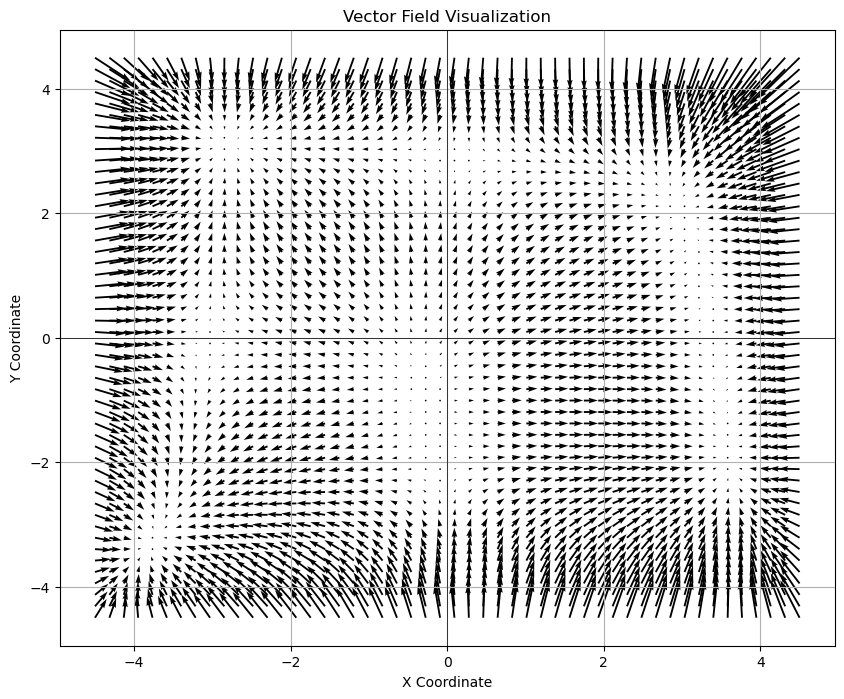

In [497]:
import matplotlib.pyplot as plt

x_values = np.linspace(-4.5, 4.5, 50)
y_values = np.linspace(-4.5, 4.5, 50)
# Generate a 2D grid of points
x_grid, y_grid = np.meshgrid(x_values, y_values)
grid_points = np.array(list(zip(x_grid.flatten(), y_grid.flatten())))

# Vectors from the calculated vector field
u_vectors = rbf(grid_points)[:,0]
v_vectors = rbf(grid_points)[:,1]

# Plotting the vector field
plt.figure(figsize=(10, 8))
plt.quiver(grid_points[:,0], grid_points[:,1], u_vectors, v_vectors, angles='xy', scale_units='xy', scale=1)
plt.title("Vector Field Visualization")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()



###### to find the steady states

In [435]:
x_values = np.linspace(-4.5, 4.5, 1000)
y_values = np.linspace(-4.5, 4.5, 1000)
# Generate a 2D grid of points
x_grid, y_grid = np.meshgrid(x_values, y_values)
grid_points_zero_search = np.array(list(zip(x_grid.flatten(), y_grid.flatten())))

result = rbf(grid_points_zero_search)

In [444]:
import numpy as np

# Assuming 'result' is a NumPy array or a DataFrame with two columns representing coordinates
# Replace this with your actual 'result' dataset
# result = ...

# Define the threshold
threshold = 8e-4
# Using numpy's isclose function to find points close to [0, 0]
close_to_origin_x = np.isclose(result[:, 0], 0, atol=threshold)  # If result is a DataFrame, use result[0]
close_to_origin_y = np.isclose(result[:, 1], 0, atol=threshold)  # If result is a DataFrame, use result[1]

# Finding indices where both x and y coordinates are close to 0
close_to_origin_indices = np.where(close_to_origin_x & close_to_origin_y)[0]
points_close_to_origin = result[close_to_origin_indices]

# Displaying the results
print(points_close_to_origin.shape)

(28, 2)


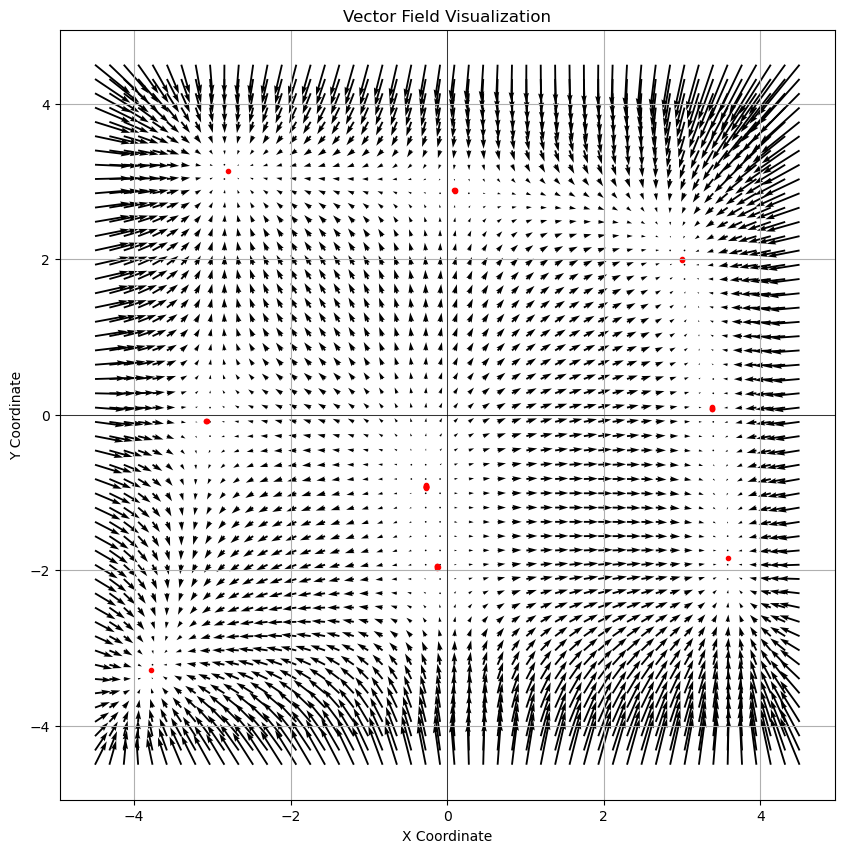

In [445]:
plt.figure(figsize=(10, 10))
plt.quiver(grid_points[:,0], grid_points[:,1], u_vectors, v_vectors, angles='xy', scale_units='xy', scale=1)
plt.scatter(grid_points_zero_search[close_to_origin_indices,0], grid_points_zero_search[close_to_origin_indices,1], marker='.',color='red')
plt.title("Vector Field Visualization")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

To obtain the states, we first retain one significant digit for the numerical values of these 28 points. Then, we eliminate the duplicates

In [506]:
np.unique(np.round(grid_points_zero_search[close_to_origin_indices], decimals=1), axis=0)

array([[-3.8, -3.3],
       [-3.1, -0.1],
       [-2.8,  3.1],
       [-0.3, -0.9],
       [-0.1, -2. ],
       [-0.1, -1.9],
       [ 0.1,  2.9],
       [ 3. ,  2. ],
       [ 3.4,  0.1],
       [ 3.6, -1.8]])

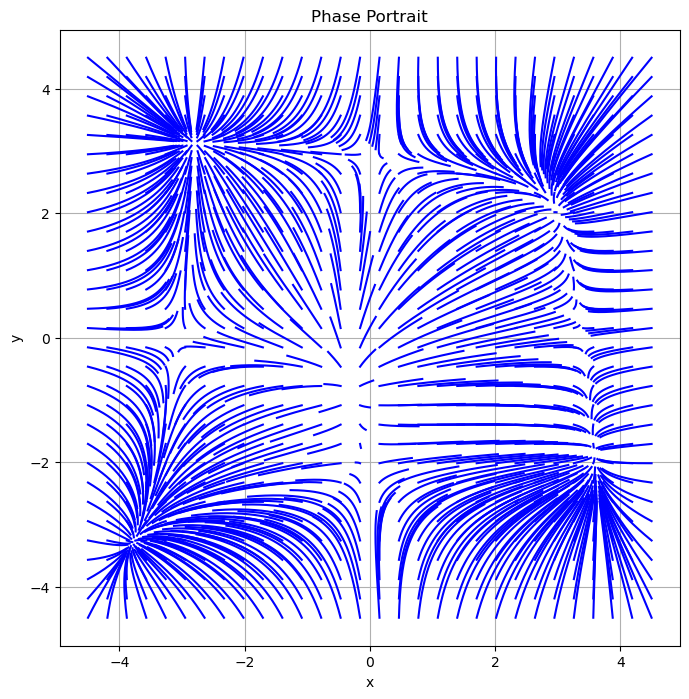

In [468]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def vector_field(x, t):
    # Example vector field: dx/dt = y, dy/dt = -x
    r = rbf(x.reshape((1,2)))
    dxdt = r[0][0]
    dydt = r[0][1]
    return [dxdt, dydt]

def plot_phase_portrait(x_range, y_range, num_points=30):
    """
    Plots the phase portrait for a given 2D vector field.

    Args:
    x_range (tuple): The range of x-values for the initial conditions (min, max).
    y_range (tuple): The range of y-values for the initial conditions (min, max).
    num_points (int): Number of points along each axis for initial conditions.
    """

    # Create a grid of initial conditions
    x_values = np.linspace(x_range[0], x_range[1], num_points)
    y_values = np.linspace(y_range[0], y_range[1], num_points)

    # Plotting
    plt.figure(figsize=(8, 8))
    for x0 in x_values:
        for y0 in y_values:
            tspan = np.linspace(0, 8, 1000)  # Adjust time span and steps as needed
            sol = odeint(vector_field, [x0, y0], tspan)
            plt.plot(sol[:, 0], sol[:, 1], '-',color="blue")

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Phase Portrait')
    plt.grid()
    plt.show()

# Example usage
plot_phase_portrait((-4.5, 4.5), (-4.5, 4.5))